In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def displace(Path,α,i,δ=0.25):
    '''Single bead displace update.
    
       NB: not implemented for periodic boundary conditions.
    '''
    # Calculate the action
    x = Path.beads[α,i]
    oldAction = Path.kinetic_action(α,i) + Path.potential_action(α)

    # Displace the bead
    Path.beads[α,i] += δ*(-1.0 + 2.0*np.random.random())

    # Compute the new action
    newAction = Path.kinetic_action(α,i) + Path.potential_action(α)
    
    # Accept the move, or reject and restore the bead position
    if np.random.random() < np.exp(-(newAction - oldAction)):
        return True
    else:
        Path.beads[α,i] = x
        return False

In [3]:
def inst_swap(Path,α,i):
    # Calculate the action
    '''Due to the reflection symmetry, the potential action does not affect change in action'''
    
    x = Path.beads[α,i]
    oldAction = Path.kinetic_action(α,i)
    
    # teleport the bead at the central slices
    Path.beads[α,i] *= (np.random.randint(0,2)*2-1)
    
    # Compute the new action
    newAction = Path.kinetic_action(α,i)
    
    # Accept the move, or reject and restore the bead position
    if np.random.random() < np.exp(-(newAction - oldAction)):
        return True
    else:
        Path.beads[α,i] = x
        return False

In [4]:
def staging(Path,m,i):
    '''Multi-slice update which eactly samples the free particle 
       propagator between two fixed beads.

       See: http://link.aps.org/doi/10.1103/PhysRevB.31.4234
    
       NB: not implemented for periodic boundary conditions.
    '''
    # choose the start and end of the stage
    α_start = np.random.randint(low=0,high=Path.num_time_slices)
    α_end = α_start + m
    
    # if we move off the end of the path, reject the move
    if α_end >= Path.num_time_slices:
        return False

    # Record the positions of the beads to be updated and store the action
    x = np.copy(Path.beads[α_start+1:α_end,i])
    oldAction = 0.0
    for α in range(α_start+1,α_end):
        oldAction += Path.potential_action(α)

    # Generate new positions and accumulate the new action
    newAction = 0.0;
    for α in range(α_start+1,α_end):
        Δτ1 = Path.Δτ   
        Δτ2 = (α_end - α)*Path.Δτ
        avex = (Δτ2*Path.beads[α-1,i] + Δτ1*Path.beads[α_end,i])\
                / (Δτ1 + Δτ2)
        σ = np.sqrt(2.0*Path.λ / (1.0/Δτ1 + 1.0/Δτ2))
        Path.beads[α,i] = np.random.normal(loc=avex,scale=σ)
        newAction += Path.potential_action(α)

    # Perform the Metropolis step, if we reject, revert the worldline
    if np.random.random() < np.exp(-(newAction - oldAction)):
        return True
    else:
        Path.beads[α_start+1:α_end,i] = x
        return False

In [5]:
# Find close position index
def find_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [40]:
class Paths:
    '''The set of worldlines, action and estimators.'''
    def __init__(self,beads,M,Δτ,λ,V_def,ω1,a,b,V0):
        self.Δτ = Δτ
        self.λ = λ
        self.M = M
        self.beads = np.copy(beads)
        self.num_time_slices = len(beads)
        self.N = len(beads[0])
        self.V_def = V_def
        self.ω1 = ω1
        self.a = a
        self.b = b
        self.V0 = V0
        
        self.norm = np.ones(self.num_time_slices)
        self.norm[0] = self.norm[-1] = 0.5

    def V(self,α,x):
        return self.V_def(self.a, self.b, self.V0, α,x)
        
    def Vint(self, xi, xj):
        '''harmonic interaction potential'''
        ωint = self.ω1
        return ωint*ωint*(xi-xj)**2 /(4.0*self.λ)
    
    def Ψ(self, xi, xj):
        '''trial wave function'''
        psi = 0.747*(np.exp(-1*((xi-1)**2)/0.5)+np.exp(-1*((xi+1)**2)/0.5))
        return psi
    
    def kinetic_action(self,α,i):
        '''kinetic action of a bead.'''
        
        if α == 0.0:
            cK = (self.beads[α+1,i]-self.beads[α,i])**2
        elif α == 2*self.M-1:
            cK = (self.beads[α,i]-self.beads[α-1,i])**2
        else:
            cK = ((self.beads[α,i]-self.beads[α-1,i])**2 + (self.beads[α+1,i]-self.beads[α,i])**2)/2
        return cK / (4*self.λ*self.Δτ)

    def potential_action(self,α):
        '''potential action of a slice.'''
        cV = 0.0
        ΨT = 1.0
            
        for i in range(self.N):
            xi = self.beads[α,i]
            cV += self.norm[α]*self.V(α,xi)
            
            for j in range(self.N):
                xj = self.beads[α,j]
                if i<j:
                    cV += self.norm[α]*self.Vint(xi, xj)    
                # add the wavefunction at the ends of the path
                if α == 0 or α == 2*self.M:
                    ΨT *= self.Ψ(xi, xj)
                
        return self.Δτ*cV - np.log(ΨT)
    

    def Energy(self):
        '''The total energy.'''
                
        # the kinetic part
        norm = 1.0/(4.0*self.λ*self.Δτ**2)
        KE = 0
        counter = 0
#         for α in range(int(self.M*0.5), int(self.M*1.5)):
        for α in range(2*self.M-1):
            for i in range(self.N):
                counter += 1
                ΔR = self.beads[α+1,i] - self.beads[α,i]
                KE +=  - norm*np.dot(ΔR,ΔR)
                
        KE /= 2*self.M
        KE += 0.5*self.N/self.Δτ
        
        # the potential part
        PE = 0.0
        counter = 0
        Vslice = np.zeros(self.num_time_slices)
#         for α in range(int(self.M*0.5), int(self.M*1.5)+1):
        for α in range(2*self.M):
            for i in range(self.N):
                cV = self.V(α,self.beads[α,i])
                for j in range(self.N):
                    if i<j:
                        cV += self.Vint(self.beads[α,i], self.beads[α,j])
                counter += 1
                Vslice[α] += self.norm[α]*cV
                PE += cV
        
        PE /= 2*self.M
        
        return KE + PE, Vslice
    


In [38]:
def pigs(num_MC_steps,num_equil_steps,Path):
    '''Perform a path integral ground state Monte Carlo simulation.'''

    # set up m
    m = int(M*0.33)
    
    # grid for density
    num_grid = 500
    grid_x = np.linspace(-4.0, 4.0, num_grid)
    drho = 1/num_grid/(num_MC_steps-num_equil_steps)
    
    # initialize estimators and acceptance counters
    numAccept = {'displace':0,'staging':0,'inst_swap':0}
    estimator = {'E':np.zeros(num_MC_steps-num_equil_steps),
                 'Vslice':np.zeros([num_MC_steps-num_equil_steps,Path.num_time_slices]), 
                 'density':np.zeros((Path.num_time_slices, num_grid))}
    


    measure = 0
    for step in range(num_MC_steps): 
        
#         # for each particle and the central slice try a tunneling move (pre-process)
#         for α in range(Path.num_time_slices):
#             for i in range(Path.N):
#                 numAccept['inst_swap'] += inst_swap(Path,α,i)
        
        
        # for each particle and slice try a displace move
        for α in range(Path.num_time_slices):
            for i in range(Path.N):
                numAccept['displace'] += displace(Path,α,i,0.5)

                
        # for each particle try a number of staging moves
        num_stage = int(Path.num_time_slices/m)
        for stage in range(num_stage):
            for i in range(Path.N): 
                numAccept['staging'] += staging(Path,m,i)
            

        # measure the energy
        if step >= num_equil_steps:
            measure = step-num_equil_steps
            estimator['E'][measure],estimator['Vslice'][measure] = Path.Energy()
            
            # store bead for a sigle particle
            for α in range(Path.num_time_slices):
                idx = find_idx(grid_x,Path.beads[α,0])
                estimator['density'][α, idx] += drho
            

    print('displace: %4.3f' %
          ((1.0*numAccept['displace'])/(num_MC_steps*Path.num_time_slices*Path.N)))
    print('staging:  %4.3f' %
          ((1.0*numAccept['staging'])/(num_MC_steps*Path.N*num_stage)))
    print('inst_swap:  %4.3f' %
          ((1.0*numAccept['inst_swap'])/(num_MC_steps*Path.num_time_slices*Path.N)))
    
    return estimator

In [28]:
def V_left(a,b,V0,α,x):
    if -b-a < x < -b+a:
        return -2*V0
    else:
        return 0

In [29]:
def V_right(a,b,V0,α,x):
    if b-a < x < b+a:
        return -2*V0
    else:
        return 0

In [16]:
def V_double(a,b,V0,α,x):
    if -b-a < x < -b+a:
        return -V0
    elif b-a < x < b+a:
        return -V0
    else:
        return 0

In [17]:
def V_shift(a,b,V0,α,x):
    if α < M:
        return V_left(a,b,V0,α,x)
    else:
        return V_right(a,b,V0,α,x)

In [18]:
def V_center(a,b,V0,α,x):
    if -a < x < +a:
        return -V0
    else:
        return 0

In [19]:
# grid for density !Must be same for those in pigs
num_grid = 500
grid_x = np.linspace(-4.0, 4.0, num_grid)

In [47]:
# setup the simulation for [tunneling]
M,N,τ,λ,ω1,a,b,V0 = 10, 1, 4.0, 0.5, 0, 0.5, 0, 2.0
Δτ = τ/M
V_setup = V_center

# random initial positions
np.random.seed(1173)
beads = -0.5 + np.random.random([2*M,N])

# setup the paths
Path = Paths(beads,M,Δτ,λ,V_setup,ω1,a,b,V0)

# compute the energy via path integral ground state Monte Carlo
num_MC_steps = 20000
num_equil_steps = 7000
estimator = pigs(num_MC_steps,num_equil_steps,Path)

from scipy.stats import sem
Ē,ΔĒ = np.average(estimator['E']),sem(estimator['E'])
V̄slice,ΔV̄slice = np.average(estimator['Vslice'],axis=0),sem(estimator['Vslice'],axis=0)

print('Ē = %f ± %f' % (Ē,ΔĒ))
E_shift = [float(Ē),float(ΔĒ)]
den_shift = np.copy(estimator['density'])

displace: 0.774
staging:  0.624
inst_swap:  0.000
Ē = -1.297936 ± 0.005177


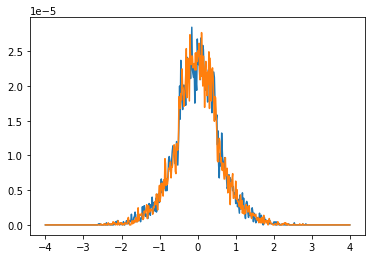

In [48]:
plt.plot(grid_x ,estimator['density'][M-1,:])
plt.plot(grid_x ,estimator['density'][M,:])

In [44]:
# Analytic value
Em = 0.907506

In [23]:
def cumulativeMovingAverage(data):
    '''Compute the cumulative mean as a function of bin index.'''
    CMA = np.zeros_like(data)
    CMA[0] = data[0]
    for n in range(len(data)-1):
        CMA[n+1] = (data[n+1] + n*CMA[n])/(1.0*(n+1))
    return CMA

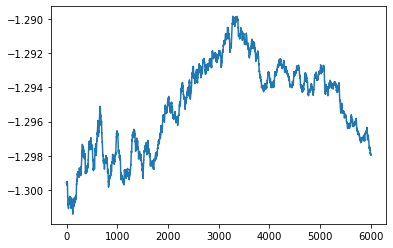

In [49]:
cumave = cumulativeMovingAverage(estimator['E'])
plt.plot(cumave[7000:])

In [26]:
# Analytic form of 𝛿 is shown below
# Em is analytic solution of the equation below (Same with E_single_well)
def delta(Path, Em):
    return 4*(V0-Em)*Em*np.exp(-2*(b-a)*np.sqrt((Em)/λ))/V0/(a*np.sqrt((Em)/λ) +1)

In [45]:
# Give delta
λ,a,b,V0 = 0.5, 0.5, 1.0, 2.0

eval = delta(Path,Em)
#eval = delta(Path,1.37179)
print(eval)

0.30800086554383094


\begin{equation}
\sqrt{V-E_{m}}=\sqrt{E_{m}}\tan\left(\sqrt{E_{m}/\lambda}a\right)
\end{equation}
\begin{equation}
\delta=4\frac{\left(V-E_{m}\right)E_{m}e^{-2\left(b-a\right)\sqrt{\left(V-E_{m}\right)/\lambda}}}{V\left(a\sqrt{\left(V-E_{m}\right)/\lambda}+1\right)}
\end{equation}

0.0
5.865693621741775


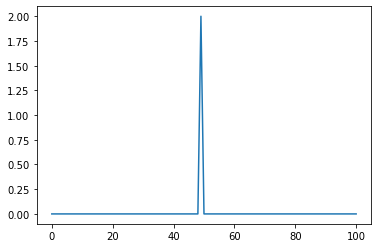

In [68]:
print(estimator['Vslice'][10000,M])
plt.plot(np.arange(2*M+1) ,estimator['Vslice'][10000])
print(estimator['E'][10000])

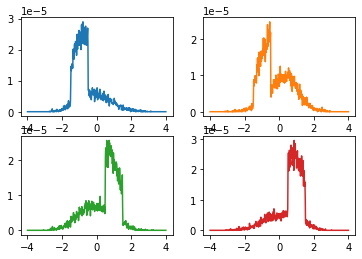

In [33]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(grid_x ,estimator['density'][M-3,:])

axs[0, 1].plot(grid_x ,estimator['density'][M-1,:], 'tab:orange')

axs[1, 0].plot(grid_x ,estimator['density'][M+1,:], 'tab:green')

axs[1, 1].plot(grid_x ,estimator['density'][M+3,:], 'tab:red')


In [25]:
D = 1.55031
measured = [2/D/D*E_shift[0],2/D/D*E_shift[1]]
print(measured)

[0.2877019164007255, 0.03918730621279735]
